In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv')

In [3]:
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

In [4]:
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
df = df.drop(['id', 'date', 'flag', 'user'], axis=1)

In [6]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

In [7]:
from sklearn.utils import shuffle

df = shuffle(df, random_state=99)

In [8]:
df = df[:100000]

In [9]:
df.shape

(100000, 2)

CPU times: user 142 ms, sys: 2.98 ms, total: 145 ms
Wall time: 152 ms


<AxesSubplot:xlabel='sentiment', ylabel='count'>

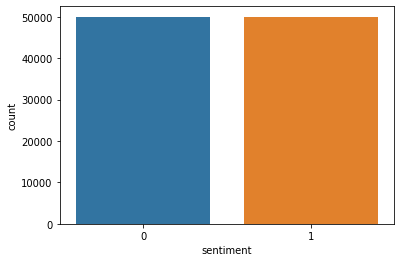

In [10]:
%%time
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
sns.countplot(data=df, x='sentiment')

In [11]:
list(encoder.inverse_transform([0, 1]))

[0, 4]

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
df['clean_text'] = df['text'].apply(clean_text)

In [14]:
stopword_list = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stopword_list)
    return text

In [15]:
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

In [16]:
df.head()

,sentiment,text,clean_text
1090970,1,"@NicolaWilts Have a creative day, hope you are...",nicolawilts creative day hope getting glorious...
444627,0,@wayneshort Yesterday: Weather &amp; trail go...,wayneshort yesterday weather amp trail gorgeo...
990835,1,surf city for my sweet zebrina ? http://blip....,surf city sweet zebrina
1311305,1,@AlohaArleen Looking forward to hearing abou...,alohaarleen looking forward hearing
1258453,1,is watching Milo and Otis,watching milo otis


In [17]:
stemmer = nltk.SnowballStemmer("english")

In [18]:
def stemming(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
%%time
df['clean_text'] = df['clean_text'].apply(stemming)

CPU times: user 17.7 s, sys: 14.4 ms, total: 17.7 s
Wall time: 17.7 s


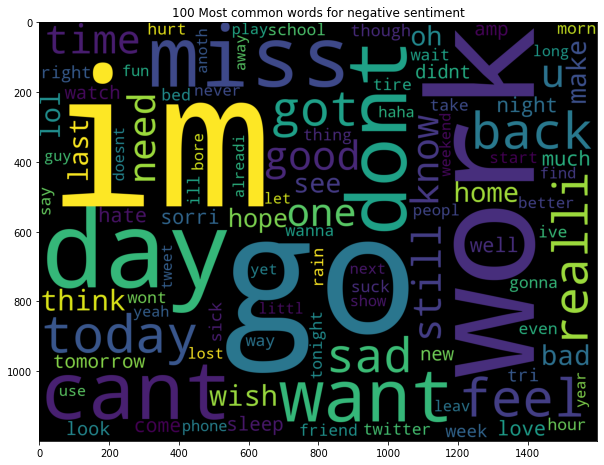

In [20]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(max_words=100, width=1600, height=1200, collocations=False).generate(" ".join(df[df['sentiment'] == 0]['clean_text']))
plt.title('100 Most common words for negative sentiment')
plt.imshow(wordcloud)

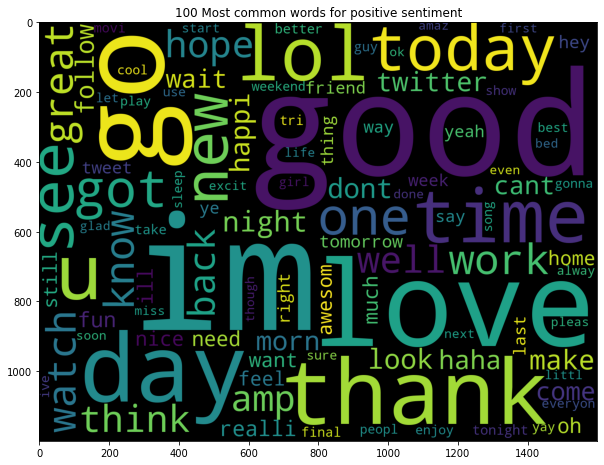

In [21]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(max_words=100, width=1600, height=1200, collocations=False).generate(" ".join(df[df['sentiment'] == 1]['clean_text']))
plt.title('100 Most common words for positive sentiment')
plt.imshow(wordcloud)
%config Completer.use_jedi = False

In [22]:
X = df['clean_text']
y = df['sentiment']

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

In [25]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=61)

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2))

tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

In [162]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report

In [163]:
def report_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test)

In [180]:
from sklearn.naive_bayes import MultinomialNB

nb_param_grid = {
    'alpha': np.linspace(0.01, 10, 100),
    'fit_prior': ['True', 'False'],
}
nb = MultinomialNB()

rs_nb = RandomizedSearchCV(estimator=nb, param_distributions= nb_param_grid, cv=3, n_iter=30, n_jobs=-1, verbose=3) 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


              precision    recall  f1-score   support

           0       0.73      0.81      0.77      4952
           1       0.79      0.70      0.74      5048

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

{'fit_prior': 'True', 'alpha': 2.3309090909090906}
CPU times: user 438 ms, sys: 81.1 ms, total: 520 ms
Wall time: 2.72 s


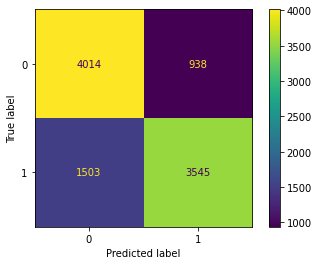

In [181]:
%%time
rs_nb.fit(X_train_tfidf, y_train)

report_performance(rs_nb.best_estimator_, X_test_tfidf, y_test)
print(rs_nb.best_params_)

In [183]:
from sklearn.naive_bayes import MultinomialNB

nb_param_grid = {
    'alpha': np.linspace(1.5, 3, 50)
}
nb = MultinomialNB(fit_prior=True)

rs_nb = RandomizedSearchCV(estimator=nb, param_distributions= nb_param_grid, cv=3, n_iter=30, n_jobs=-1, verbose=3) 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


              precision    recall  f1-score   support

           0       0.73      0.81      0.77      4952
           1       0.79      0.70      0.74      5048

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

{'alpha': 2.295918367346939}
CPU times: user 430 ms, sys: 68.1 ms, total: 498 ms
Wall time: 2.7 s


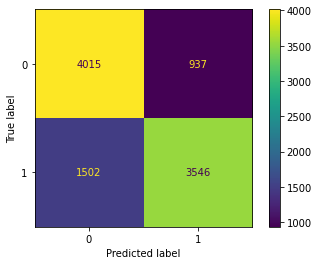

In [184]:
%%time
rs_nb.fit(X_train_tfidf, y_train)

report_performance(rs_nb.best_estimator_, X_test_tfidf, y_test)
print(rs_nb.best_params_)

In [176]:
from sklearn.svm import LinearSVC

svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'dual': [True, False],
    'C': [0.01, 0.1, 1, 10, 100]
}

svc = LinearSVC()

rs_svc = RandomizedSearchCV(estimator=svc, param_distributions= svc_param_grid, cv= 3, n_iter= 20, n_jobs= -1, verbose=10)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4952
           1       0.76      0.76      0.76      5048

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

{'penalty': 'l2', 'dual': True, 'C': 0.1}
CPU times: user 846 ms, sys: 148 ms, total: 994 ms
Wall time: 2min 40s


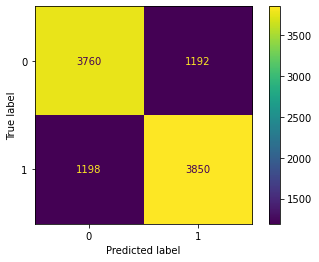

In [177]:
%%time
rs_svc.fit(X_train_tfidf, y_train)
report_performance(rs_svc.best_estimator_, X_test_tfidf, y_test)
print(rs_svc.best_params_)

In [178]:
svc_param_grid = {
    'C': np.linspace(0.01, 1, 20)
}

svc = LinearSVC(dual=True, penalty='l2')

rs_svc = GridSearchCV(estimator=svc, param_grid= svc_param_grid, cv= 5, n_jobs= -1, verbose=10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.9s finished


              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4952
           1       0.77      0.76      0.77      5048

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

{'C': 0.21842105263157896}
CPU times: user 1.15 s, sys: 110 ms, total: 1.26 s
Wall time: 28.6 s


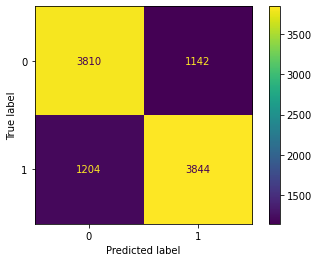

In [179]:
%%time
rs_svc.fit(X_train_tfidf, y_train)
report_performance(rs_svc.best_estimator_, X_test_tfidf, y_test)
print(rs_svc.best_params_)

In [103]:
from sklearn.ensemble import RandomForestClassifier

rfc_param_grid = {
    'n_estimators': [32, 64, 100, 150, 200],
    'max_features': [1, 5, 10, 50, 100],
    'bootstrap': ['True', 'False']
}

rfc = RandomForestClassifier(max_depth=100)

rs_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_param_grid, cv=3, n_iter=10, n_jobs=-1, verbose=10)

In [104]:
rs_rfc.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  6.9min remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=100),
                   n_jobs=-1,
                   param_distributions={'bootstrap': ['True', 'False'],
                                        'max_features': [1, 5, 10, 50, 100],
                                        'n_estimators': [32, 64, 100, 150,
                                                         200]},
                   verbose=10)

              precision    recall  f1-score   support

           0       0.76      0.71      0.74      4952
           1       0.73      0.78      0.76      5048

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

{'n_estimators': 150, 'max_features': 100, 'bootstrap': 'True'}


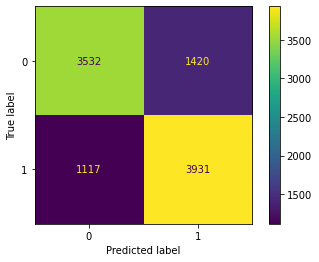

In [105]:
report_performance(rs_rfc.best_estimator_, X_test_tfidf, y_test)
print(rs_rfc.best_params_)

In [186]:
from sklearn.ensemble import RandomForestClassifier

rfc_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': [100, 200, 300, 500]
}

rfc = RandomForestClassifier(max_depth=100, bootstrap=True, verbose=3, n_jobs=-1)

rs_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=3, n_jobs=-1, verbose=10)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 56.0min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 62.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.4s


building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min


building tree 125 of 150
building tree 126 of 150
building tree 127 of 150
building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.76      0.71      0.73      4952
           1       0.73      0.78      0.75      5048

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished


{'max_features': 500, 'n_estimators': 150}


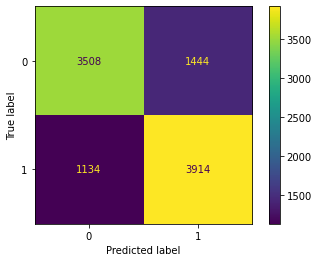

In [187]:
rs_rfc.fit(X_train_tfidf, y_train)
report_performance(rs_rfc.best_estimator_, X_test_tfidf, y_test)
print(rs_rfc.best_params_)

In [148]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

error_rate = []

for n in range(0, 10):
    ada = AdaBoostClassifier(n_estimators=(n*50)+1)
    ada.fit(X_train_tfidf, y_train)
    preds = ada.predict(X_test_tfidf)
    err = 1-accuracy_score(y_test, preds)
    error_rate.append(err)
    print(n)

0
1
2
3
4
5
6
7
8
9


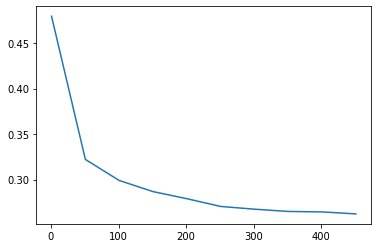

In [149]:
plt.plot([1, 51, 101, 151, 201, 251, 301, 351, 401, 451], error_rate)

In [138]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    'n_estimators': [32, 64, 100, 150, 200],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_depth': [2, 5, 10, 25, 50, 100]
}

gb = GradientBoostingClassifier()

rs_gb = RandomizedSearchCV(estimator=gb, param_distributions=gb_param_grid, cv=3, n_iter=10, n_jobs=-1, verbose=10)

In [139]:
rs_gb.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.6min remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10, 25, 50, 100],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                                        'n_estimators': [32, 64, 100, 150,
                                                         200]},
                   verbose=10)

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      4952
           1       0.63      0.71      0.67      5048

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

{'n_estimators': 200, 'max_features': 10, 'max_depth': 25}


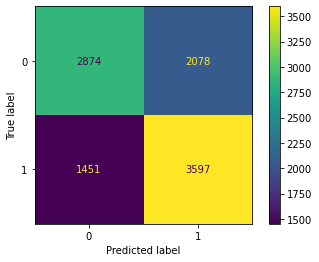

In [140]:
report_performance(rs_gb.best_estimator_, X_test_tfidf, y_test)
print(rs_gb.best_params_)

In [221]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv')
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df = df.drop(['id', 'date', 'flag', 'user'], axis=1)
df = shuffle(df, random_state=99)
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
X = df['text']
y = df['sentiment']
X_train = X[:1400000]
y_train = y[:1400000]
X_val = X[1400000:]
y_val = y[1400000:]

In [222]:
from sklearn.base import BaseEstimator

class TextCleaner(BaseEstimator):
    
    def __init__(self):
        pass
    
    def fit(self, documents, y=None):
        return self

    def transform(self, X):
        stopword_list = stopwords.words('english')
        stemmer = nltk.SnowballStemmer("english")
        for text in X:
            text = str(text).lower()
            text = re.sub('\[.*?\]', '', text)
            text = re.sub('https?://\S+|www\.\S+', '', text)
            text = re.sub('<.*?>+', '', text)
            text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
            text = re.sub('\n', '', text)
            text = re.sub('\w*\d\w*', '', text)
            text = ' '.join(word for word in text.split(' ') if word not in stopword_list)
            text = ' '.join(stemmer.stem(word) for word in text.split(' '))

        return X

In [223]:
%%time 
from sklearn.pipeline import Pipeline

finalModelPipe = Pipeline([('textclean', TextCleaner()), ('tfidf', TfidfVectorizer(ngram_range=(1, 2))), ('finalLSVC', LinearSVC(dual=True, penalty='l2', C=0.22))])

finalModelPipe.fit(X_train, y_train)

CPU times: user 6min 19s, sys: 2.22 s, total: 6min 21s
Wall time: 6min 21s


Pipeline(steps=[('textclean', TextCleaner()),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('finalLSVC', LinearSVC(C=0.22))])

              precision    recall  f1-score   support

           0       0.83      0.83      0.83    100114
           1       0.83      0.83      0.83     99885

    accuracy                           0.83    199999
   macro avg       0.83      0.83      0.83    199999
weighted avg       0.83      0.83      0.83    199999

{'n_estimators': 200, 'max_features': 10, 'max_depth': 25}


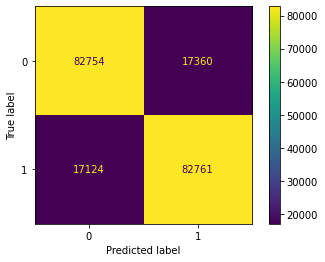

In [225]:
report_performance(finalModelPipe, X_val, y_val)
print(rs_gb.best_params_)

In [229]:
import joblib

joblib.dump(finalModelPipe, 'finalTwitterModel.pkl')

['finalTwitterModel.pkl']

In [230]:
loadedModel = joblib.load('finalTwitterModel.pkl')

In [232]:
loadedModel.predict(['that was a #great #performance'])

array([1])